<h1>IBM Quantum Challenge Africa 2021</h1>
<p style="font-size:xx-large;">Introduction and the Crop-Yield Problem</p>

Quantum Computing has the potential to revolutionize computing, as it can solve problems that are not possible to solve on a classical computer. This extra ability that quantum computers have is called quantum advantage. To achieve this goal, the world needs passionate and competent end-users: those who know how to apply the technology to their field.

In this challenge you will be exposed, at a high-level, to quantum computing through Qiskit. As current or future users of quantum computers, you need to know what problems are appropriate for quantum computation, how to structure the problem model/inputs so that they are compatible with your chosen algorithm, and how to execute a given algorithm and quantum solution to solve the problem.

This is the first notebook for the IBM Quantum Challenge Africa. Before starting here, ensure you have completed the Week 0 content in preparation for the following exercises.

## Initialization

To ensure the demonstrations and exercises have the required Python modules and libraries, run the following cell before continuing.

In [1]:
# Import auxiliary libraries
import numpy as np

# Import Qiskit
from qiskit import IBMQ, Aer
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer.noise.noise_model import NoiseModel

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

import qiskit.test.mock as Fake

## Table of Contents

The notebook is structured as follows:

1. Initialization
2. Table of Contents
3. Qiskit and its parts
4. Setting up the Qiskit Environment
5. Quadratic Problems
6. Crop-Yield Problem as a Quadratic Problem
7. Solving the Crop-Yield Problem using Quantum Computing
8. Simulating a Real Quantum Computer for the Crop-Yield Problem

## Qiskit and its parts

Qiskit is divided into multiple modules for different purposes, with Terra at the core of the Qiskit ecosystem. It helps to be familiar with what each module can do and whether you will need to utilize the software contained within them for your specific problem. There are four modules that deal with the application of quantum computing; with tools and algorithms built specifically for their fields.

Have a quick look at the [Qiskit documentation](https://qiskit.org/overview) and this IBM Research [blog post](https://www.ibm.com/blogs/research/2021/04/qiskit-application-modules/) to see what these modules are called. Once you have done so, you can complete the first exercise of the challenge: replace the ficticious module names, in the python cell below, with the correct module names. Though it would be fun to have a Qiskit Gaming module, it has not yet been developed. If you are interested in contributing to the open-source Qiskit community, have a look at the [contribution guide](https://qiskit.org/documentation/contributing_to_qiskit.html).

### Exercise 1a: Qiskit Applications Modules

#### Solution

**Qiskit Optimization** is an open-source framework that covers the whole range from high-level modeling of optimization problems, with automatic conversion of problems to different required representations, to a suite of easy-to-use quantum optimization algorithms that are ready to run on classical simulators, as well as on real quantum devices via Qiskit.

**Qiskit Nature** is an open-source framework that supports problems including ground state energy computations, excited states and dipole moments of molecule, both open and closed-shell.

**Qiskit Finance** is an open-source framework that contains uncertainty components for stock/securities problems, Ising translators for portfolio optimizations and data providers to source real or random data to finance experiments.

**Qiskit Machine Learning** package simply contains sample datasets at present. It has some classification algorithms such as QSVM and VQC (Variational Quantum Classifier), where this data can be used for experiments, and there is also QGAN (Quantum Generative Adversarial Network) algorithm.


In [2]:
# The Real Qiskit module names

qiskit_module_names = [
    "Qiskit Optimization",
    "Qiskit Nature",
    "Qiskit Finance",
    "Qiskit Machine Learning",
]

In [3]:
qiskit_module_names

['Qiskit Optimization',
 'Qiskit Nature',
 'Qiskit Finance',
 'Qiskit Machine Learning']

Run the following python cell to check if you have the correct module names.

In [4]:
from qc_grader import grade_ex1a

grade_ex1a(qiskit_module_names)

/opt/conda/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


Submitting your answer for ex1/partA. Please wait...
Failed: Error wrong data received.


### Qiskit Applications Modules

In this notebook, we will use the `Qiskit Optimization` applications module for a specific problem to illustrate how

1. classical and mathematical problem definitions are represented in Qiskit,
2. some quantum algorithms are defined,
3. to execute a quantum algorithm for a given problem definition,
4. and algorithms and Qiskit problems are executed on real and simulated quantum computers.

We will also be using Qiskit Terra and Aer as they provide the foundation of Qiskit and high-performance quantum simulators respectively.

## Quadratic Problems

Some computational problems can be formulated into quadratic equations such that the minimum of the quadratic equations is the optimal solution, if any exist. These problems are encountered in finance, agriculture, operations and production management, and economics.

Quadratic programming is also used to identify an optimal financial portfolio with minimum risk and optimizing the layout of production components in a factory to minimize the travel distance of resources. This notebook focuses on agriculture as it is a relevant application of quantum computing to problems facing the African continent. However, all of these applications share two common characteristics: the system can be modelled as a quadratic equation and the system variables may be constrained, with their values limited to within a given range.

---

Quadratic problems take on the following structure. Given a vector of $n$ variables $x\in\mathbb{R}^n$, the quadratic function to minimize is as follows.

$$
\begin{align}
\text{minimize}\quad & f\left(x\right)=\frac{1}{2}x^\top{}\mathbf{Q}x + c^\top{}x &\\
\text{subject to}\quad & \mathbf{A}x\leq{}b&\\
& x^\top{}\mathbf{Q}_ix + c_{i}^\top{}x\leq{}r_i,\quad&\forall{}i\in[1,k_q]\\
& l_i\leq{}x_i\leq{}u_i,\quad&\forall{}i\in[1,k_l]\\
\end{align}
$$

$\mathbf{Q}$, $\mathbf{Q}_i$, and $\mathbf{A}$ are $n\times{}n$ symmetric matrices. $c$ and $c_i$ are $n\times{}1$ column vectors. $\mathbf{Q}_i$, $\mathbf{A}$, $c_i$, $l_i$, and $u_i$ define constraints on the variables in $x$. The quadratic equation at the core of the quadratic problem is found by multiplying out the matrices in the minimization function. Though '$\leq{}$' is used in the constraint equations above, any identity relationship may be used for any number of constraints: i.e. "$<$", "$=$", "$>$", "$\geq$", or "$\leq$".

A valid solution to the quadratic must satisfy all conditions for the problem. Examples of some constraints are given below. The first two are linear constraints whereas the third example is a quadratic constraint.

$$ x_1 + x_4 \leq{} 10$$

$$ x_2 - 3x_6 = 10$$

$$x_1x_2 - 4x_3x_4 + x_5 \leq{} 15 $$


Qiskit has Python code that allows you to implement a quadratic problem as a `QuadraticProgram` instance. Though our definition above used matrices to define the coefficients, `QuadraticProgram` allows you to define the objective (function overwhich to minimize) directly. To illustrate how to use `QuadraticProgram`, we will use the following quadratic problem definition, with three integer variables.

$$\begin{align}
\text{minimize}\quad{} & f(x)=(x_1)^2 + (x_2)^2 - x_1x_2 - 6x_3 \\
\text{subject to}\quad{} & x_1 + x_2 = 2             \\
                         & x_2x_3 \geq{} 1           \\
                         & -2 \leq{} x_2 \leq{} 2    \\
                         & -2 \leq{} x_3 \leq{} 4    \\
\end{align}$$

The figure below shows the constraints on $x_1$ and $x_3$, with some simplifcation. The shaded area denotes valid values for $x_1$ and $x_3$, within which $f(x)$ must be minimized.

<img src="quadratic_example.svg" width=512px/>

In the following code, the above quadratic problem is defined as a `QuadraticProgram` instance. Have a look at the [Qiskit documentation for `QuadraticProgram`](https://qiskit.org/documentation/stubs/qiskit.optimization.QuadraticProgram.html), as it can be very useful in helping your understanding of its interface.

The quadratic to minimize, called an objective, is implemented using dictionaries. This allows you, the developer, to explicitly define coefficients for specific variables and terms. The keys in the dictionaries are the variable names identifying a term in $f(x)$. For example, `("x_1","x_2")` is for $x_1x_2$. The values for each item are the coefficients for said terms. Terms that are subtracted in $f(x)$ must have a negative coefficient.

In [5]:
quadprog = QuadraticProgram(name="example 1")
quadprog.integer_var(name="x_1", lowerbound=0, upperbound=4)
quadprog.integer_var(name="x_2", lowerbound=-2, upperbound=2)
quadprog.integer_var(name="x_3", lowerbound=-2, upperbound=4)
quadprog.minimize(
    linear={"x_3": -6},
    quadratic={("x_1", "x_1"): 1, ("x_2", "x_2"): 1, ("x_1", "x_2"): -1},
)
quadprog.linear_constraint(linear={"x_1": 1, "x_2": 1}, sense="=", rhs=2)
quadprog.quadratic_constraint(quadratic={("x_2", "x_3"): 1}, sense=">=", rhs=1)

A `QuadraticProgram` can have three types of variables: binary, integer, and continuous. The Qiskit implementation of the algorithms we are going to use currently only support binary and integer variables. There are other algorithms that allow for the simulation of continuous variables, but they are not covered in this notebook. If you want to know more about them though, have a look at this Qiskit tutorial on [algorithms to solve mixed-variable quadratic problems](https://qiskit.org/documentation/tutorials/optimization/5_admm_optimizer.html).

We can visualize the `QuadraticProgram` as an LP string, a portable text-based format used representating the model as a **L**inear **P**rogramming problem.

In [6]:
print(quadprog.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: example 1

Minimize
 obj: - 6 x_3 + [ 2 x_1^2 - 2 x_1*x_2 + 2 x_2^2 ]/2
Subject To
 c0: x_1 + x_2 = 2
 q0: [ x_2*x_3 ] >= 1

Bounds
       x_1 <= 4
 -2 <= x_2 <= 2
 -2 <= x_3 <= 4

Generals
 x_1 x_2 x_3
End



Any optimization problem that can be represented as a single second-order equation, in that the greatest exponent of any term is 2, can be transformed into a quadratic problem or program of the form given above. The above example is arbitrary and does not necessarily represent a given real-world problem. The main problem of this notebook focuses on optimizing the yield of a farm, though only the problem definition need be changed to apply this technique to other quadratic problem applications.

## Crop-Yield Problem as a Quadratic Problem

To show how to solve your quadratic program using a quantum computer, we will use two algorithms to solve the crop-yield problem. It is a common need to optimize the crops and management of a farm to reduce risk while increasing profits. One of the big challenges facing Africa and the whole world is how to produce enough food for everyone. The problem here focuses not on profits but on the tonnage of crops harvested. Imagine you have a farm with three hectares of land suitable for farming. You need to choose which crops to plant from a selection of four. Furthermore, you also need to determine how many hectares of each you should plant. The four crops you can plant are wheat, soybeans, maize, and a push-pull crop. The fourth cannot be sold once harvested but it can help increase the yield of the other crops.

<table>
    <tr>
        <th>
            <img src="farm_template.svg" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            Our beautiful three hectare farm
        </th>
    </tr>
</table>

<table>
    <tr>
        <th>
        <img src="crop_wheat.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_soybeans.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_maize.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_pushpull.svg" width="256px"/>
        </th>
    </tr>
    <tr>
        <th>
            Wheat
        </th>
        <th>
            Soybeans
        </th>
        <th>
            Maize
        </th>
        <th>
            Push-Pull
        </th>
<!--         <th>
            <p align="right" style="height:32px;padding-top:10px;">Wheat<img src="wheat.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Soybeans<img src="soybeans.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Maize<img src="maize.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Push-Pull<img src="pushpull.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th> -->
    </tr>
</table>

There are three types of farming methods we can use: monocropping, intercropping, and push-pull farming. These are shown below. Monocropping is where only one crop is farmed. This is can make the farm susceptible to disease and pests as the entire yield would be affected. In some instances, growing two different plants nearby each other will increase the yield of both, though sometimes it can decrease the yield. Intercropping is the process where different plants are chosen to _increase_ the yield. Push-Pull crops are pairs of plants that repel pests and attract pests respectively. Integrating them into a larger farm increases the yield of harvested food but with the cost of not necessarily being able to use the harvest of Push-Pull crops as part of the total yield. This is because the Push-Pull crop may not be usable or even edible.

<table>
    <tr>
        <th>
        <img src="farm_mono.svg" width="256px"/>
        </th>
        <th>
            <img src="farm_intercrop.svg" width="256px"/>
        </th>
        <th>
            <img src="farm_intercrop_pushpull.svg" width="256px"/>
        </th>
    </tr>
    <tr>
        <th>
            Monocropping
        </th>
        <th>
            Intercropping
        </th>
        <th>
            Push-Pull farming
        </th>
    </tr>
</table>

---
Only in certain cases can quadratic programming problems be solved easily using classical problems. In their general sense, they are NP-Hard; a class of problems that is difficult to solve using classical computational methods. In fact, the best classical method to solve these problems involves heuristics, a technique that finds an approximate solution. Quantum Computers have been shown to provide significant speed-up and better scaling for some heuristic problems. The crop-yield problem is a combinatorial problem, in that the solution is a specific combination of input parameters. Though the problem shown here is small enough to solve classically, larger problems become intractable on a classical computer owing to the number of combinations of which to optimize.


Solving the above problem using quantum computing involves three components:

1. Defining the problem
2. Defining the algorithm
3. Executing the algorithm on a backend

Many problems in Qiskit follow this structure as the algorithm you use can typically be swapped for another without significantly redefining your problem. Execution on different backends is the easiest, as long as the device has sufficient resource. The first component is given below, with the second and third in sections 1.5 and 1.6.

### Define the Crop-Yield problem

The following problem is defined for you but the `QuadraticProgram` is not implemented. Your task at the end of this section is to implement the `QuadraticProgram` for the given crop-yield model.

Your farm has three hectares available, $3~ha$, with each crop taking up $0~ha$ or $1~ha$. We define the yield of the farm as a quadratic function where the influence of each crop on eachother is represented by the quadratic coefficients. The variables in this quadratic are the number of hectares of the crop to be planted and the objective function to maximize is the yield of usable crops in tons. Here is the mathematical model for the problem. In this scenario, all crops increase the yield of other crops. However, the problem to solve is which crops to use to achieve the maximum yield.

<img src="qubo_problem_graphical_variables.svg" width="534px"/>

The farm yield, in tons, is modelled as a quadratic equation, given below, with constraints on the hectares used by each crop and the total hectares available. Each crop is shown using a different symbol, as shown above, representing the number of hectares to be planted of said plant. Note that we can only plant up to 1 hectare of each crop and that our farm is constrained to 3 hectares.

<img src="qubo_problem_graphical.svg" width="400px"/>

----
#### Non-graphical notation
Here is a non-graphical representation of the above model, if you are struggling to interpret the above graphic.

$$
\begin{align}
    \text{maximize} \quad & 2(\operatorname{Wheat}) + \operatorname{Soybeans} + 4(\operatorname{Maize}) \\
    & + 2.4(\operatorname{Wheat}\times\operatorname{Soybeans}) \\ & + 4(\operatorname{Wheat}\times\operatorname{Maize})\\
    &+ 4(\operatorname{Wheat}\times\operatorname{PushPull}) \\ & + 2(\operatorname{Soybeans}\times\operatorname{Maize}) \\
                          & + (\operatorname{Soybeans}\times\operatorname{PushPull}) \\ & + 5(\operatorname{Maize}\times\operatorname{PushPull})
\end{align}
$$

$$
\begin{align}
\text{subject to} \quad & \operatorname{Wheat} + \operatorname{Soybeans} + \operatorname{Maize} + \operatorname{PushPull} \leq{} 3\\
& 0\leq{}\operatorname{Wheat}\leq{}1\\
& 0\leq{}\operatorname{Soybeans}\leq{}1\\
& 0\leq{}\operatorname{Maize}\leq{}1\\
& 0\leq{}\operatorname{PushPull}\leq{}1
\end{align}
$$

### Exercise 1b: Create Quadratic Program from crop-yield variables

Your first exercise is to create a `QuadraticProgram` that represents the above model. Write your implementation in the `cropyield_quadratic_program` function below. Remember to use the example as a guide, and to look at the [QuadraticProgram documentation](https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html?highlight=quadraticprogram) and [Qiskit reference](https://qiskit.org/documentation/stubs/qiskit.optimization.QuadraticProgram.html?highlight=quadraticprogram#qiskit.optimization.QuadraticProgram).

**Note:** Ensure your variables are named `Wheat`, `Soybeans`, `Maize,` and `PushPull`. This is necessary for the grader to work.

#### Solution

Above there are four different crop options to choose from to achieve a maximum yield: `Wheat`, `Soybeans`, `Maize`, and `PushPull`. To maximize the amount for each of these crops, they need to be turned into variables for the QuadraticProgram. The the specified function, each crop has an lower and upper bound at 0 and 1, respectively. Next is defining the maximize function. The first line for maximizing, $2(Wheat)+Soybeans+4(Maize)$, is the linear part because we don't see two variables multiplying with one another. The other parts of the function are part of the quadratic in the maximize function because variables are multiplying with one another. The scalar in front is also used to define the linear and quadratic parts fo the maximize function.

linear: $\alpha(var)$ $\rightarrow$ $var: \alpha$

quadratic: $\alpha(var0 \times var1)$ $\rightarrow$ $(var0, var1): \alpha$



In [7]:
def cropyield_quadratic_program():
    cropyield = QuadraticProgram(name="Crop Yield")
    ##############################
    # Put your implementation here
    cropyield.integer_var(name='Wheat', lowerbound=0, upperbound=1)
    cropyield.integer_var(name='Soybeans', lowerbound=0, upperbound=1)
    cropyield.integer_var(name='Maize', lowerbound=0, upperbound=1)
    cropyield.integer_var(name='PushPull', lowerbound=0, upperbound=1)
    cropyield.maximize(
        linear={'Wheat': 2, 'Soybeans': 1, 'Maize': 4},
        quadratic={('Wheat', 'Soybeans'): 2.4, ('Wheat', 'Maize'): 4, ('Wheat', 'PushPull'): 4, ('Soybeans', 'Maize'): 2,
        ('Soybeans', 'PushPull'): 1, ('Maize', 'PushPull'): 5}
    )
    cropyield.linear_constraint(linear={'Wheat': 1, 'Soybeans': 1, 'Maize': 1, 'PushPull': 1}, sense='<=', rhs=3)
    #
    ##############################
    return cropyield

Once you feel your implementation is correct, you can grade your solution in the following cell.

In [8]:
cropyield = cropyield_quadratic_program()
print(cropyield.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Crop Yield

Maximize
 obj: 2 Wheat + Soybeans + 4 Maize + [ 4.800000000000 Wheat*Soybeans
      + 8 Wheat*Maize + 8 Wheat*PushPull + 4 Soybeans*Maize
      + 2 Soybeans*PushPull + 10 Maize*PushPull ]/2
Subject To
 c0: Wheat + Soybeans + Maize + PushPull <= 3

Bounds
       Wheat <= 1
       Soybeans <= 1
       Maize <= 1
       PushPull <= 1

Generals
 Wheat Soybeans Maize PushPull
End



In [9]:
# Execute this cell to grade your solution
from qc_grader import grade_ex1b

cropyield = cropyield_quadratic_program()
grade_ex1b(cropyield)

Submitting your answer for ex1/partB. Please wait...
Failed: Error wrong data received.


### Converting QuadraticPrograms

If we want to estimate how many qubits this quadratic program requires, we can convert it to an Ising Model and print the `num_qubits` parameter. An [ising model](https://qiskit.org/documentation/apidoc/qiskit.optimization.applications.ising.html?highlight=ising) is a special system model type that is well suited for quantum computing. Though we will not be using an ising model explicitly, the algorithms and Qiskit classes we are using do this conversion internally.

In [10]:
# Estimate the number of qubits required
ising_operations, _ = (
    QuadraticProgramToQubo()
    .convert(
        cropyield,
    )
    .to_ising()
)
print(f"Number of qubits required is {ising_operations.num_qubits}")

Number of qubits required is 6


Even though quadratic programs are widely used in Qiskit, the algorithms we are going to use require binary variables. Qiskit provides an automated method for converting our integer variables into binary variables. The binary-only form is called a _Quadratic Unconstrained Binary Optimization_ problem, or `QUBO`. The conversion is done using `QuadraticProgramToQUBO` from the Qiskit optimization module. Every integer variable, and their associated constraints, are transformed into binary variables.

Run the following code to see how the QUBO version of the cropyield problem looks. Notice how the quadratic becomes longer and more variables are added. This is to account for the bits in each variable, including the constraints. When we run our quantum algorithm to solve this QuadraticProgram, it is converted to a QUBO instance within the Qiskit algorith implementation, implicitly.

In [11]:
QuadraticProgramToQubo().convert(cropyield)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Crop Yield

Minimize
 obj: - 160.400000000000 Wheat@0 - 159.400000000000 Soybeans@0
      - 162.400000000000 Maize@0 - 158.400000000000 PushPull@0
      - 158.400000000000 c0@int_slack@0 - 316.800000000000 c0@int_slack@1 + [
      52.800000000000 Wheat@0^2 + 100.800000000000 Wheat@0*Soybeans@0
      + 97.600000000000 Wheat@0*Maize@0 + 97.600000000000 Wheat@0*PushPull@0
      + 105.600000000000 Wheat@0*c0@int_slack@0
      + 211.200000000000 Wheat@0*c0@int_slack@1 + 52.800000000000 Soybeans@0^2
      + 101.600000000000 Soybeans@0*Maize@0
      + 103.600000000000 Soybeans@0*PushPull@0
      + 105.600000000000 Soybeans@0*c0@int_slack@0
      + 211.200000000000 Soybeans@0*c0@int_slack@1 + 52.800000000000 Maize@0^2
      + 95.600000000000 Maize@0*PushPull@0
      + 105.600000000000 Maize@0*c0@int_slack@0
      + 211.200000000000 Maize@0*c0@int_slack@1 + 52.800000000000 PushPull@0^2
      + 105.600000000000 PushPu

## Solving the Crop-Yield Problem using a Quantum Computer

There are three ways to _run_ a quantum algorithm using Qiskit:
1. on a simulator locally on your own machine
2. on a simulator hosted in the cloud by IBM
3. on an actual quantum computer accessible through IBM Quantum.

All of these are called backends. In all cases, the _backend_ can easily be swapped for another as long as the simulator or device has appropriate resources (number of qubits etc.). In the code below, we show how to access different backends. We demonstrate this using the local Aer QASM simulator from Qiskit. The Aer QASM simulator models the physical properties of a real quantum computer so you, researchers, and developers can test their quantum computing code and algorithms before running on real devices.

In [12]:
# We will use the Aer provided QASM simulator
backend = Aer.get_backend("qasm_simulator")

# Given we are using a simulator, we will fix the algorithm seed to ensure our results are reproducible
algorithm_globals.random_seed = 271828

We would like to compare our quantum solution to that obtained classically. Secondly, we also want to try different algorithms. The following three subsections show how these different methods for solving the Crop-Yield problem are implemented in Qiskit. The two algorithms used are the [_Quantum Approximate Optimization Algorithm_](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html?highlight=qaoa#qiskit.algorithms.QAOA) `QAOA` and the [_Variational Quantum Eigensolver_](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html?highlight=vqe#qiskit.algorithms.VQE) `VQE`.

Both of these algorithms are hybrid, in that they use a classical _optimizer_ to alter parameters that affect the quantum computation. The VQE algorithm is used to find the lowest eigenvalue of a matrix, which can describe a system to optimize. The QAOA also finds the lowest eigenvalue, but achieves this is a different way to VQE. Both are very popular algorithms, with varying applications and strengths.

### Classical Solution

The classical solution to the crop-yield problem can easily be found using Numpy and Qiskit. The QUBO problem can be solved by finding the minimum eigenvalue of its underlying matrix representation. Fortunately, we don't have to know what this matrix looks like. We only need to pass it to a `MinimumEigensolver` and `MinimumEigenOptimizer`.

The optimizer translates the provided problem into a parameterised representation which is then passed to the solver. By optimizing the paramters, the solver will eventually give the minimum eigenvalue for the parameterized representation and thus the solution to the original problem. Here we use a classical solver from NumPy, the `NumPyMinimumEigensolver`.

In [13]:
def get_classical_solution_for(quadprog: QuadraticProgram):
    # Create solver
    solver = NumPyMinimumEigensolver()

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Return result from optimizer
    return optimizer.solve(quadprog)

If we execute the classical method for our crop-yield problem, we get a valid solution that maximises the yield.

In [14]:
# Get classical result
classical_result = get_classical_solution_for(cropyield)

# Format and print result
print("Solution found using the classical method:\n")
print(f"Maximum crop-yield is {classical_result.fval} tons")
print(f"Crops used are: ")

_crops = [v.name for v in cropyield.variables]
for cropIndex, cropHectares in enumerate(classical_result.x):
    print(f"\t{cropHectares} ha of {_crops[cropIndex]}")

Solution found using the classical method:

Maximum crop-yield is 19.0 tons
Crops used are: 
	1.0 ha of Wheat
	0.0 ha of Soybeans
	1.0 ha of Maize
	1.0 ha of PushPull


### QAOA Solution

To solve our problem using QAOA, we need only replace the classical_solver with a `QAOA` class instance. Now that we are running a quantum algorithm, we need to tell the solver where to execute the quantum component. We use a `QuantumInstance` to store the backend information. The QAOA is an iterative algorithm, and thus is run multiple times with different internal parameters. The parameters are tuned classically during the optimization step of the computation by `optimizer`. If we leave `optimizer` as `None`, our algorithms will use the default optimization algorithm. To determine how many iterations there are, we define a callback function that runs for each iteration and stores the number of evaluations thus far. At the end of our algorithm execution, we return the result and the number of iterations.

In [15]:
def get_QAOA_solution_for(
    quadprog: QuadraticProgram, quantumInstance: QuantumInstance, optimizer=None,
):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count

    # Create solver
    solver = QAOA(
        optimizer=optimizer, quantum_instance=quantumInstance, callback=callback,
    )

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Get result from optimizer
    result = optimizer.solve(quadprog)
    return result, _eval_count

If we execute the QAOA method for our crop-yield problem, we get the same result as the classical method, showing that 1) the quantum solution is correct and 2) that you now know how to use a quantum algorithm! 🌟

In [16]:
# Create a QuantumInstance
simulator_instance = QuantumInstance(
    backend=backend,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

# Get QAOA result
qaoa_result, qaoa_eval_count = get_QAOA_solution_for(cropyield, simulator_instance)

# Format and print result
print("Solution found using the QAOA method:\n")
print(f"Maximum crop-yield is {qaoa_result.fval} tons")
print(f"Crops used are: ")
for cropHectares, cropName in zip(qaoa_result.x, qaoa_result.variable_names):
    print(f"\t{cropHectares} ha of {cropName}")

print(f"\nThe solution was found within {qaoa_eval_count} evaluations of QAOA.")

Solution found using the QAOA method:

Maximum crop-yield is 19.0 tons
Crops used are: 
	1.0 ha of Wheat
	0.0 ha of Soybeans
	1.0 ha of Maize
	1.0 ha of PushPull

The solution was found within 3 evaluations of QAOA.


### VQE Solution

The `VQE` algorithm works in a very similar way to the `QAOA`. Not only in a mathematical modelling and algorithmic perspective, but also programmatically. There is a quantum solver and a classical optimizer. The `VQE` instance is also iterative, and so we can measure how many iterations are needed to find a solution to the Crop-Yield problem.

In [17]:
def get_VQE_solution_for(
    quadprog: QuadraticProgram, quantumInstance: QuantumInstance, optimizer=None,
):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count

    # Create solver and optimizer
    solver = VQE(
        optimizer=optimizer, quantum_instance=quantumInstance, callback=callback
    )

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Get result from optimizer
    result = optimizer.solve(quadprog)
    return result, _eval_count

And we should get the exact same answer as before.

In [18]:
# Create a QuantumInstance
simulator_instance = QuantumInstance(
    backend=backend,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

# Get VQE result
vqe_result, vqe_eval_count = get_VQE_solution_for(cropyield, simulator_instance)

# Format and print result
print("Solution found using the VQE method:\n")
print(f"Maximum crop-yield is {vqe_result.fval} tons")
print(f"Crops used are: ")
for cropHectares, cropName in zip(vqe_result.x, vqe_result.variable_names):
    print(f"\t{cropHectares} ha of {cropName}")

print(f"\nThe solution was found within {vqe_eval_count} evaluations of VQE")

Solution found using the VQE method:

Maximum crop-yield is 19.0 tons
Crops used are: 
	1.0 ha of Wheat
	0.0 ha of Soybeans
	1.0 ha of Maize
	1.0 ha of PushPull

The solution was found within 25 evaluations of VQE


### Exercise 1c: Classical and Quantum Computational Results

From the above computations you received six results, the maximum crop-yield and the number of evaluations for three different methods. The maximum yield values should be the same. If your yield values aren't all the same, rerun the algorithms. Sometimes the optimization process can miss the correct answer because of the randomness used to initialize the algorithm parameters.

Run the code cell below to see if the maximum yields you computed are correct.

#### Solution

Here we see that the max yield for optimizing with QAOA and VQE are the same, confirming our results.

In [19]:
from qc_grader import grade_ex1c

max_yield_qaoa = qaoa_result.fval
max_yield_vqe = vqe_result.fval

print(max_yield_qaoa)
print(max_yield_vqe)

grade_ex1c(tonnage_qaoa=max_yield_qaoa, tonnage_vqe=max_yield_vqe)

19.0
19.0
Submitting your answer for ex1/partC. Please wait...
Failed: Error wrong data received.


_You could always verify your result with the classical method, though this is only possible here given the size of the problem. Larger problems become more difficult to verify._

## Simulating a Real Quantum Computer for the Crop-Yield Problem

Sometimes one would want to _simulate_ a real quantum computer to see how the actual hardware may impact the performance of the algorithm. All quantum computers have an underlying architecture, different noise characeristics, and error rates. These three aspects impact how well the algorithm can perform on a given deivce. To test the impact a given quantum computer has on the QAOA instance, we can utilize a _fake_ instance of the device in Qiskit to tell our simulator what parameters to use. In this example we will be simulating `ibmq_johannesburg`, a device named after the city of Johannesburg in South Africa.

In [20]:
fake_device = Fake.FakeJohannesburg()

We can inspect what this device _looks_ like using the Qiskit Jupyter tools, shown below. You do not need to know about this structure to execute quantum programs on a device, but it is useful to visualize the parameters.

In [21]:
import qiskit.tools.jupyter

fake_device

<FakeJohannesburg('fake_johannesburg')>

The three aforementioned components of a quantum computer are represented as a noise model, coupling map, and the basis gate set. The noise model is a representation of how the noise and errors in the computer behave. The coupling map and basis gate set are core to the architecture of the device. The coupling map represents how the physical qubits can interact whereas the basis gate set is analogous to the set of fundamental computatonal instructions we can use. You can see the coupling map in the above widget as the lines connecting each qubit in the architecture diagram.

To simulate `ibmq_johannesburg`, we must pass these three components to our Aer simulator.

In [22]:
# Create the noise model, which contains the basis gate set
noise_model = NoiseModel.from_backend(fake_device)

# Get the coupling map
coupling_map = fake_device.configuration().coupling_map

Next we create a new `QuantumInstance` with these parameters

In [23]:
fake_instance = QuantumInstance(
    backend=backend,
    basis_gates=noise_model.basis_gates,
    coupling_map=coupling_map,
    noise_model=noise_model,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

We can then execute the `QAOA` from before on this new _fake_ quantum device.

In [24]:
# Get QAOA result
qaoa_result, qaoa_eval_count = get_QAOA_solution_for(cropyield, fake_instance)

# Format and print result
print("Solution found using the QAOA method:\n")
print(f"Maximum crop-yield is {qaoa_result.fval} tons")
print(f"Crops used are: ")
for cropHectares, cropName in zip(qaoa_result.x, qaoa_result.variable_names):
    print(f"\t{cropHectares} ha of {cropName}")

print(f"\nThe solution was found within {qaoa_eval_count} evaluations of QAOA.")

Solution found using the QAOA method:

Maximum crop-yield is 19.0 tons
Crops used are: 
	1.0 ha of Wheat
	0.0 ha of Soybeans
	1.0 ha of Maize
	1.0 ha of PushPull

The solution was found within 3 evaluations of QAOA.


### Scaling of the Quantum Solution vs Classical

When we created our quadratic program for the crop-yield problem, we saw that the Ising Model required 6 qubits. We had constrained our problem such that we could only plant up to 1 hectare per crop. However, we could change the model so that we can plot 3 hectares per crop, upto our maximum available farm area of 3 hectares.

How many qubits would this ising model require?

---

Furthermore, what if we had more land to farm? We know that this problem is NP-Hard and thus classical solutions are mostly found using heuristics. This is the core reason why quantum computers are promising to solve these kinds of problems. But what are the resource requirements for the quantum solution, with a larger farm and crops that can be planted in more hectares?

To illustrate this, we've provided a function that returns the number of qubits required by the underlying Ising Model for the Crop-Yield Problem. We then see the estimated number of qubits needed for different problem parameters. Feel free to modify the variables being used to see how the qubit resource requirements change.

In [25]:
# Function to estimate the number of qubits required
def estimate_number_of_qubits_required_for(max_hectares_per_crop, hectares_available):
    return int(
        4 * np.ceil(np.log2(max_hectares_per_crop + 1))
        + np.ceil(np.log2(hectares_available + 1))
    )


# Our new problem parameters
hectares_available = 10
max_hectares_per_crop = 10

# Retrieving the number of qubits required
number_of_qubits_required = estimate_number_of_qubits_required_for(
    max_hectares_per_crop=max_hectares_per_crop, hectares_available=hectares_available
)

print(
    f"Optimizing a {hectares_available} ha farm with each crop taking up to {max_hectares_per_crop} ha each,",
    f"the computation is estimated to require {number_of_qubits_required} qubits.",
)

Optimizing a 10 ha farm with each crop taking up to 10 ha each, the computation is estimated to require 20 qubits.


The number of qubits required is related to the constraints in the quadratic program and how the integer variables are converted to binary variables. In fact, the scaling of the number of qubits, as a function of the hectares available, is logarithmic in nature; owing to this conversion.

## Running on real quantum hardware

To use the IBM Quantum platform is easy. First you need to load the account you enabled in the week 0 content. If you didn't complete this, follow this [quick guide](https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq) on connecting your IBM Quantum account with Qiskit in python and Jupyter.

In [26]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

IBM Quantum backends are accessed through a provider, which manages the devices to which you have access. For this challenge, you have access to the new `ibm_perth` quantum computer! Typically, you would find your provider details under your [IBM Quantum account details](https://quantum-computing.ibm.com/account). Under your account you can see the different hubs, groups, and projects you are a part of. Qiskit allows us to retrieve a provider using just the hub, group, and project as follows:

```python
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
```

However, because we have given you special access for this challenge, we are going to retrive the provider using a different method. Execute the code cell below to retrieve the correct provider.

In [27]:
provider = None
for prov in IBMQ.providers():
    if (
        "iqc-africa-21" in prov.credentials.hub
        and "q-challenge" in prov.credentials.group
        and "ex1" in prov.credentials.project
    ):
        # Correct provider found
        provider = prov
        
if provider == None:
    print("ERROR: The expected provider was not found!")
else:
    print("Yay! The expected provider was found!")

Yay! The expected provider was found!


If the above code cell returned an error, you may not yet have access to the real quantum computer. The list of participants is updated daily, so you may have to wait some time before the correct provider appears. If you need assistance, send a message to the challenge Slack channel [#challenge-africa-2021](https://qiskit.slack.com/archives/C02C8MKP153) and make sure to tag the admin team with [@africa_admin](#).

------

To retrieve a backend from the provider, one needs only request it by name. For example, we can request `ibm_perth` as follows.

In [28]:
backend_real = provider.get_backend("ibm_perth")

We can also list all backends available through a given backend. In this example we use the _open_ provider as it has access to all open devices and simulators, instead of the limited few for the challenge.

In [29]:
for _backend in IBMQ.get_provider(hub='ibm-q', group='open', project='main').backends():
    print(_backend.name())

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


Qiskit provides visual tools to view backend information in a jupyter notebook. To accomplish this, one needs to import the `jupyter` submodule and call the appropriate _magic comment_. With `qiskit_backend_overview` you can view all devices accessible by the current IBMQ account. Notice how it does not include simulators. Furthermore, you should see that all devices available through the _open group_ have at most 5 qubits. This is a problem for solving the crop-yield problem we created earlier, as we showed it requires 6 qubits.

To demonstrate how a real quantum device is used, a smaller `QuadraticProgram` is provided, requiring a maximum of 4 qubits.

In [30]:
%qiskit_backend_overview

<div class="alert alert-block alert-warning">
    
If you want access to larger and more sophisticated quantum computers through IBM, see if your university or company is part of the [IBM Quantum Network](https://www.ibm.com/quantum-computing/network/members/). Researchers are institutions that are part of the [African Research Universities Alliance (ARUA)](https://arua.org.za/) can also apply for access through the University of the Witwatersrand, in South Africa; which is a member of the IBM Quantum Network. If you are a researcher, you can also apply for access through the [IBM Quantum Researchers Program](https://www.ibm.com/quantum-computing/researchers-program/). If you're a student at a highschool or university, you can ask your teachers or lecturers to apply for access through the [IBM Quantum Educators Program](https://www.ibm.com/quantum-computing/educators-program/).

</div>

Given that we have imported `qiskit.tools.jupyter`, Jupyter will now display a helpful widget when an IBMQ backend is displayed. We do not have to use a _magic comment_ here as the jupyter submodule defines how some variables are displayed in a jupyter notebook, without requiring a _magic comment_.

In [31]:
backend_real

<IBMQBackend('ibm_perth') from IBMQ(hub='iqc-africa-21-3', group='q-challenge-3', project='ex1-recSYZD99j7o71x9L')>

We can create a new `QuantumInstance` object to contain our real quantum computer backend, similar to how we created one to manage our simulator. For real devices, there is an extra parameter we can set: `shots`. The output of a quantum computing algorithm is probabilistic. Therefore, we must execute the quantum computation multiple times, sampling the outputs to estimate their probabilities. The number of `shots` is the number of executions of the quantum computation. Here we set out `QuantumInstance` to use the least busy backend with 2048 shots.

In [32]:
quantum_instance_real = QuantumInstance(backend_real, shots=2048)

The VQE algorithm and QAOA are iterative, meaning that they incorporate a classical-quantum loop which repeats certain computations, _hopefully_ converging to a valid solution. In each iteration, or evaluation, the quantum backend will execute the quantum operations 2048 times. Each shot is quite fast, so we do not have to worry about a significant increase in processing time by using more shots.

----
We now define our small crop-yield problem, which only requires 4 qubits. In this example, only Wheat and Maize are used. The model is altered to illustrate the impact of growing too much of a single crop, with the yield decreasing as the number of hectares of a single crop is increased. However, utilizing both wheat and maize increases yield, showing the benefits of intercropping.

**NB:** The maximum number of hectares available is 4, but given that the model would never exceed this limit, the linear constraint defining the maximum number of hectares is not included. This reduces the number of qubits required from 6 to 4.

In [33]:
# Create a small crop-yield example quadratic program
cropyield_small = QuadraticProgram(name="Small Crop-Yield")

# Add two variables, indicating whether we grow 0, 1, or 2 hectares for two different crops
cropyield_small.integer_var(lowerbound=0, upperbound=2, name="Wheat")
cropyield_small.integer_var(lowerbound=0, upperbound=2, name="Maize")

# Add the objective function defining the yield in tonnes
cropyield_small.maximize(
    linear={"Wheat": 3, "Maize": 3},
    quadratic={("Maize", "Wheat"): 1, ("Maize", "Maize"): -2, ("Wheat", "Wheat"): -2},
)

# This linear constraint is not used as the model never reaches this. This is because the
# sum of the upperbounds on both variables is 4 already. If this constraint is applied, the
# model would require 6 qubits instead of 4.
# cropyield_small.linear_constraint(linear={"Wheat": 1, "Maize": 1}, sense="<=", rhs=4)

print(cropyield_small)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Small Crop-Yield

Maximize
 obj: 3 Wheat + 3 Maize + [ - 4 Wheat^2 + 2 Wheat*Maize - 4 Maize^2 ]/2
Subject To

Bounds
       Wheat <= 2
       Maize <= 2

Generals
 Wheat Maize
End



Here we verify that our small crop-yield problem requires only 4 qubits.

In [34]:
# Estimate the number of qubits required
ising_operations_small, _ = (
    QuadraticProgramToQubo()
    .convert(
        cropyield_small,
    )
    .to_ising()
)
print(f"Number of qubits required is {ising_operations_small.num_qubits}")

Number of qubits required is 4


### Exercise 1d: Submitting a job to a real quantum computer

Now that we know the problem can be run on our chosen device, we can execute the VQE algorithm. In this case we will set the optimizer, with a maximum number of iterations of 1, so that we do not occupy the device for too long. Our answer will be incorrect, but we only want to see how to send a quantum program to a real quantum computer.

In [35]:
# Create our optimizer
optimizer = COBYLA(maxiter=1)

## Get result from real device with VQE
vqe_result_real, vqe_eval_count_real = get_VQE_solution_for(
    cropyield_small, quantum_instance_real, optimizer=optimizer
)

/opt/conda/lib/python3.8/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


Qiskit uses `jobs` to track computations and their results on remote devices and simulators. We can query the backend object for the jobs it received, which would be those created by the VQE algorithm.

In [36]:
# Retrieve the VQE job sent
job_real = backend_real.jobs()[0]

print(f"VQE job created at {job_real.creation_date()} and has a job id of {job_real.job_id()}")

VQE job created at 2021-09-23 14:09:51.472000+00:00 and has a job id of 614c8aafaf74f71ee141240b


Put the job id for your the above job into the cell below and execute the code cell.

#### Solution

Select the job id that was created from the code block above.

In [37]:
from qc_grader import grade_ex1d

job_id = job_real.job_id()

grade_ex1d(job_id)

Submitting your answer for ex1/partD. Please wait...
Failed: Error wrong data received.


To verify that our job actually was completed, we can view the results as shown below.

In [39]:
result = job_real.result()

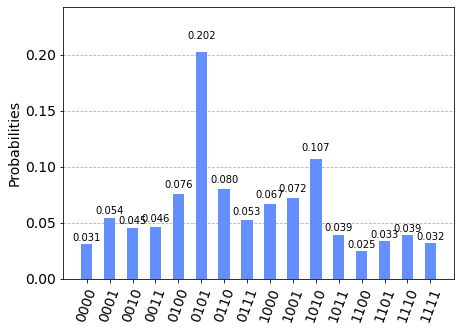

In [40]:
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

You have now completed the first lab of the IBM Quantum Challenge Africa 2021! Make sure that you are on the [Qiskit Slack channel](https://ibm.co/Africa_Slack) so you can ask questions and talk to other participants. There are two more labs left in the challenge, which are more difficult than this introductory lab, covering quantum computing for finance and HIV.

## References

[1] A. A. Nel, ‘Crop rotation in the summer rainfall area of South Africa’, South African Journal of Plant and Soil, vol. 22, no. 4, pp. 274–278, Jan. 2005, doi: 10.1080/02571862.2005.10634721.

[2] H. Ritchie and M. Roser, ‘Crop yields’, Our World in Data, 2013, [Online]. Available: https://ourworldindata.org/crop-yields.

[3] G. Brion, ‘Controlling Pests with Plants: The power of intercropping’, UVM Food Feed, Jan. 09, 2014. https://learn.uvm.edu/foodsystemsblog/2014/01/09/controlling-pests-with-plants-the-power-of-intercropping/ (accessed Feb. 15, 2021).

[4] N. O. Ogot, J. O. Pittchar, C. A. O. Midega, and Z. R. Khan, ‘Attributes of push-pull technology in enhancing food and nutrition security’, African Journal of Agriculture and Food Security, vol. 6, pp. 229–242, Mar. 2018.

In [38]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.2
qiskit-aer,0.9.0
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.5
qiskit,0.30.0
qiskit-nature,0.2.1
qiskit-finance,0.2.1
qiskit-optimization,0.2.2
qiskit-machine-learning,0.2.1
